In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
from mmctools.helper_functions import covariance

In [5]:
# read sonic data from west boom
%time df = pd.read_csv('/Users/equon/WFIP2/PS12/sonic80w.csv',parse_dates=['datetime']).set_index('datetime')

CPU times: user 25 s, sys: 3.19 s, total: 28.2 s
Wall time: 26.2 s


In [6]:
df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)

In [7]:
df['wdir'] = 270. - np.degrees(np.arctan2(-df['u'],-df['v']))
df.loc[df['wdir']<0,'wdir'] += 360.

In [8]:
not_east = (df['wdir'] < (90-22.5)) | (df['wdir'] > (90+22.5))

In [9]:
len(df.loc[not_east]) / len(df)

0.985375771779209

In [10]:
df = df.loc[not_east]

In [11]:
df = df.sort_index()

In [12]:
df.head()

,u,v,w,Tv,wspd,wdir
datetime,,,,,,
2016-07-15 13:17:23,10.48,-0.29,-0.76,283.99,10.484012,358.414930
2016-07-15 13:17:24,11.05,0.13,-0.36,283.89,11.050765,360.674037
2016-07-15 13:17:25,10.75,-0.38,-0.35,283.97,10.756714,357.975504
2016-07-15 13:17:26,10.93,0.00,-0.59,284.28,10.930000,360.000000
2016-07-15 13:17:27,10.54,-0.19,-0.58,284.06,10.541712,358.967266


## calculate turbulence metrics

In [13]:
offset = '10min'

In [14]:
%%time
uu = df['u'].resample(offset).var()
vv = df['v'].resample(offset).var()
ww = df['w'].resample(offset).var()

CPU times: user 2.11 s, sys: 316 ms, total: 2.42 s
Wall time: 2.43 s


In [15]:
uv = covariance(df['u'],df['v'],offset,resample=True)

In [16]:
meanwind = df['wspd'].resample(offset).mean()

In [17]:
ang = np.arctan2(df['v'].resample(offset).mean(),
                 df['u'].resample(offset).mean())
TI = uu*np.cos(ang)**2 + uv*2*np.sin(ang)*np.cos(ang) + vv*np.sin(ang)**2
TI = 100 * np.sqrt(TI) / meanwind

In [18]:
k = 0.5*(uu + vv + ww)

In [19]:
TI_est = 100 * np.sqrt(2./3.*k) / meanwind

## comparison

In [20]:
starttime = pd.to_datetime('2016-11-01')
endtime = pd.to_datetime('2016-11-28')

In [21]:
TIdir = r"$\sigma_u = \sqrt{\overline{u'u'}\cos^2\lambda + 2*\overline{u'v'}\sin\lambda\cos\lambda + \overline{v'v'}\sin^2\lambda}$"

In [22]:
TIxyz = r'$\sigma_u = \sqrt{2k/3}$'

In [23]:
TIratio = 100 * TI_est/TI
TIratio_mean = np.mean(TIratio)

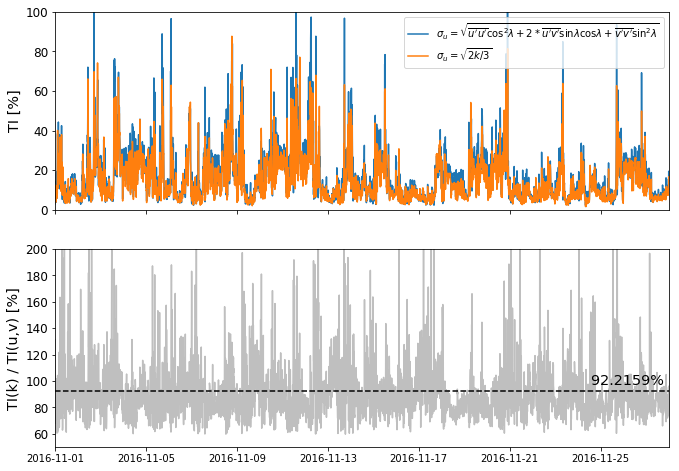

In [24]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))

ax[0].plot(TI.index, TI, label=TIdir)
ax[0].plot(TI_est.index, TI_est, label=TIxyz)
ax[0].set_ylim((0,100))
ax[0].set_ylabel('TI [%]',fontsize='x-large')
ax[0].tick_params(axis='y',labelsize='large')

ax[1].plot(TI.index, TIratio,'0.5',alpha=0.5)
ax[1].axhline(TIratio_mean,color='k',ls='--')
ax[1].set_ylim((50,200))
ax[1].set_ylabel('TI(k) / TI(u,v) [%]',fontsize='x-large')
ax[1].tick_params(axis='y',labelsize='large')
ax[1].text(endtime, TIratio_mean+5, '{:g}% '.format(TIratio_mean),
           fontsize='x-large', horizontalalignment='right')

ax[0].set_xlim((starttime,endtime))
ax[0].legend()

In [25]:
hr = TI.index.hour

In [26]:
day_frac = hr/24.

(-5.425026781438513,
 113.92556241020877,
 -5.434961284952337,
 114.13418698399906)

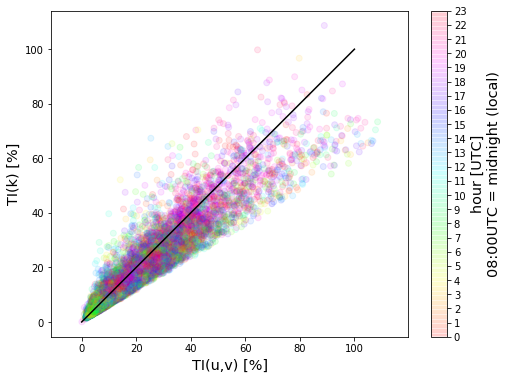

In [27]:
fig,ax = plt.subplots(figsize=(8,6))
scat = ax.scatter(TI,TI_est,alpha=0.1,c=day_frac,cmap='hsv')
ax.plot([0,100],[0,100],'k-')
cbar = fig.colorbar(scat)
cbar.set_ticks(np.arange(24)/24.)
cbar.set_ticklabels(np.arange(24))
cbar.set_label('hour [UTC]\n08:00UTC = midnight (local)',fontsize='x-large')
ax.set_xlabel('TI(u,v) [%]',fontsize='x-large')
ax.set_ylabel('TI(k) [%]',fontsize='x-large')
ax.axis('equal')

In [28]:
# local 06:00 to 18:00 (14Z to 02Z)
daytime = (hr >= 14) | (hr <= 2)
nighttime = ~daytime

(-5.340129107472692,
 112.14271125692653,
 -5.434961284952337,
 114.13418698399906)

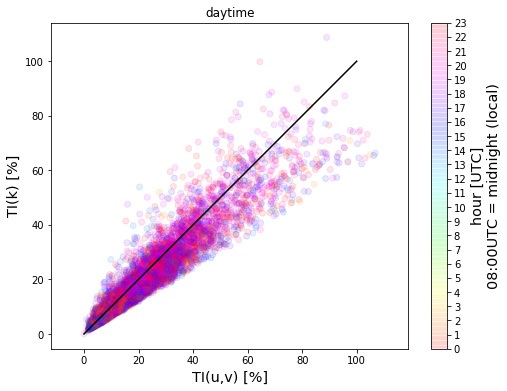

In [29]:
fig,ax = plt.subplots(figsize=(8,6))
scat = ax.scatter(TI[daytime],TI_est[daytime],c=day_frac[daytime],alpha=0.1,cmap='hsv')
ax.plot([0,100],[0,100],'k-')
ax.set_title('daytime')
cbar = fig.colorbar(scat)
cbar.set_ticks(np.arange(24)/24.)
cbar.set_ticklabels(np.arange(24))
cbar.set_label('hour [UTC]\n08:00UTC = midnight (local)',fontsize='x-large')
ax.set_xlabel('TI(u,v) [%]',fontsize='x-large')
ax.set_ylabel('TI(k) [%]',fontsize='x-large')
ax.axis('equal')

(-5.425026781438513, 113.92556241020877, -5.0, 105.0)

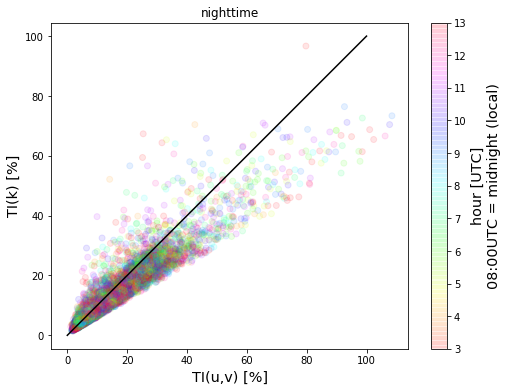

In [30]:
fig,ax = plt.subplots(figsize=(8,6))
scat = ax.scatter(TI[nighttime],TI_est[nighttime],c=day_frac[nighttime],alpha=0.1,cmap='hsv')
ax.plot([0,100],[0,100],'k-')
ax.set_title('nighttime')
cbar = fig.colorbar(scat)
cbar.set_ticks(np.arange(24)/24.)
cbar.set_ticklabels(np.arange(24))
cbar.set_label('hour [UTC]\n08:00UTC = midnight (local)',fontsize='x-large')
ax.set_xlabel('TI(u,v) [%]',fontsize='x-large')
ax.set_ylabel('TI(k) [%]',fontsize='x-large')
ax.axis('equal')

In [31]:
from scipy.linalg import lstsq

In [32]:
def fit_line(x,y):
    valid = np.isfinite(x)
    a = np.empty((len(x[valid]),1))
    a[:,0] = x[valid]
    m,resid,rank,s = lstsq(a, y[valid])
    return m[0]

/Users/equon/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/equon/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/equon/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

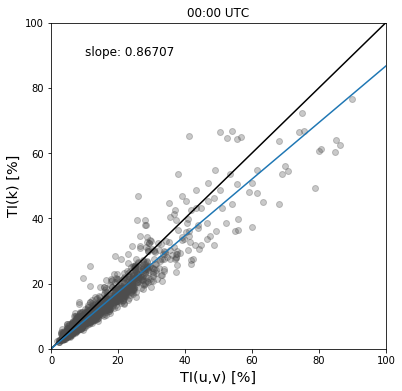

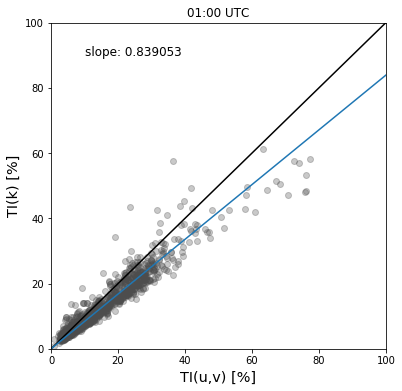

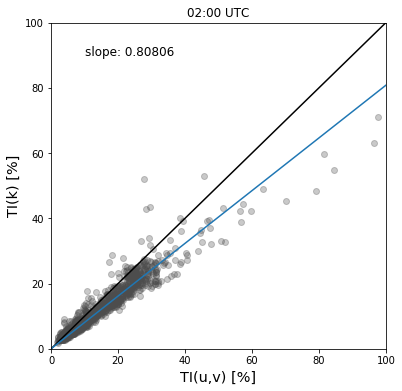

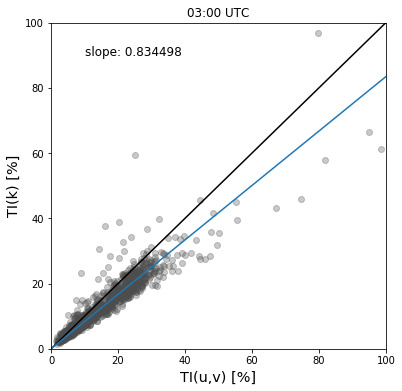

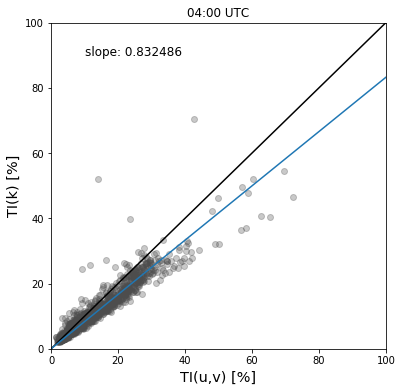

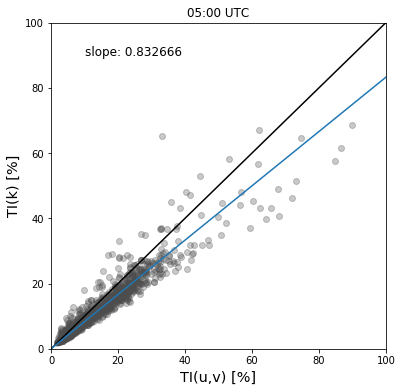

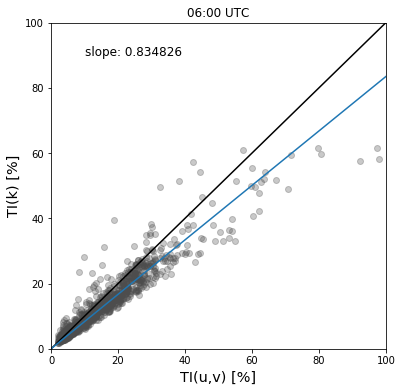

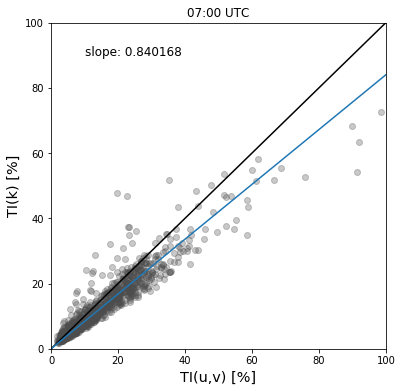

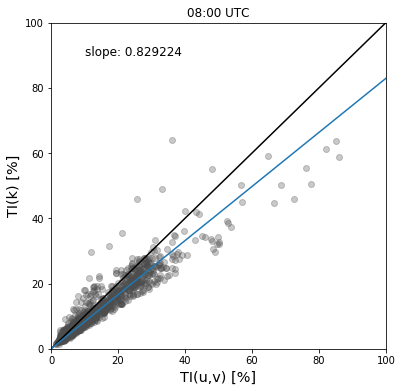

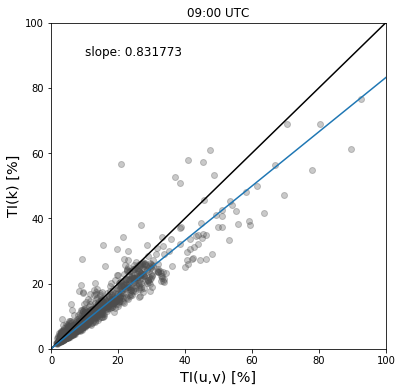

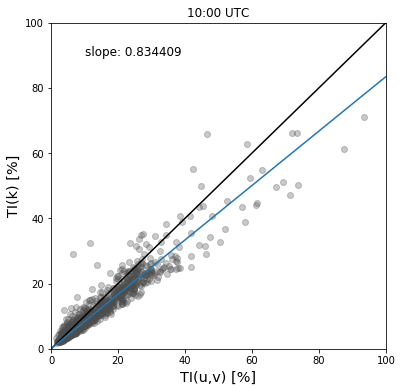

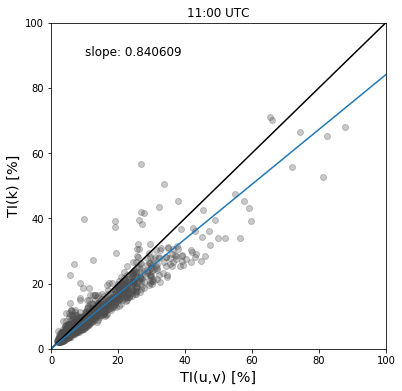

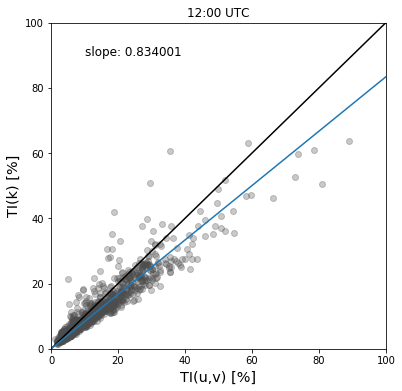

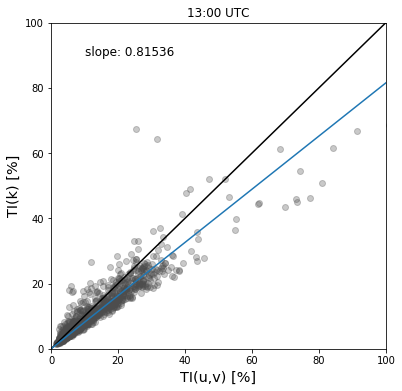

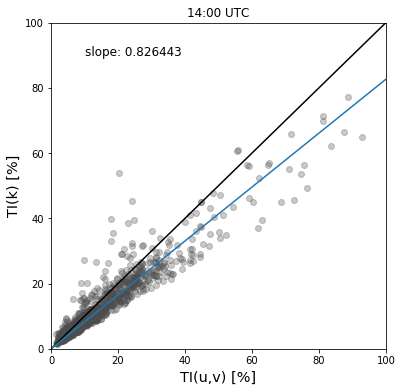

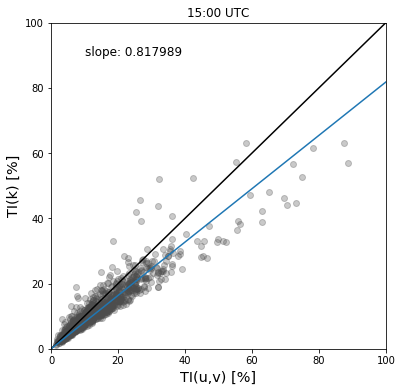

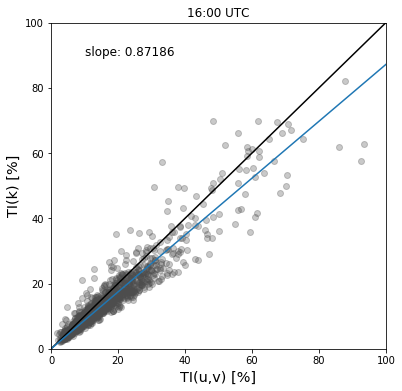

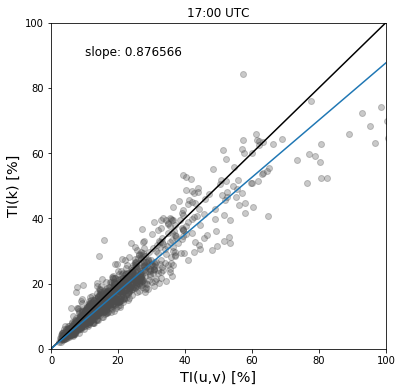

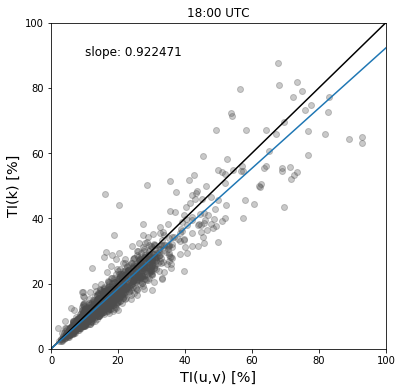

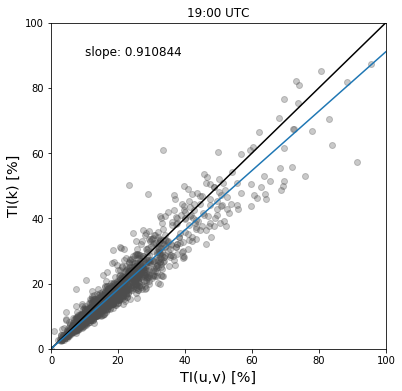

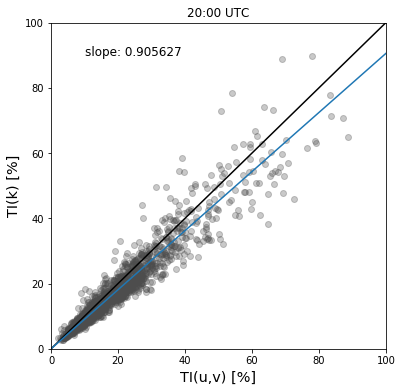

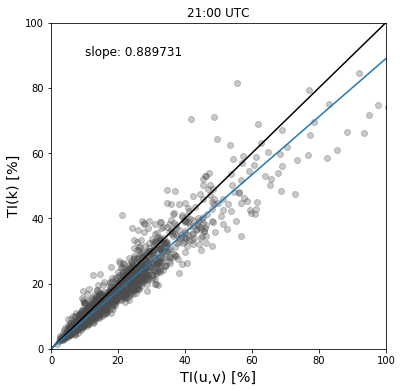

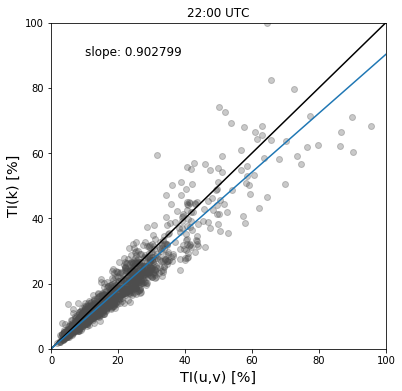

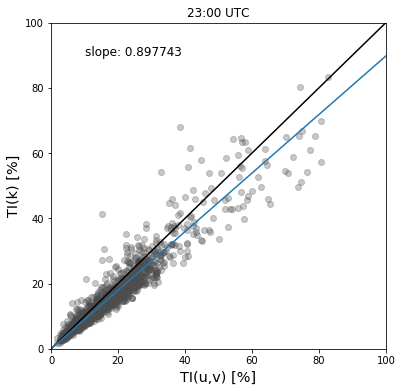

In [35]:
slopes = []
for i in range(24):
    fig,ax = plt.subplots(figsize=(6,6))
    selected = (hr == i)
    scat = ax.scatter(TI[selected],TI_est[selected],c='0.3',alpha=0.3)
    ax.plot([0,100],[0,100],'k-')
    m = fit_line(TI[selected],TI_est[selected])
    slopes.append(m)
    ax.plot([0,100],[0,100*m])
    ax.text(10,90,'slope: {:g}'.format(m),fontsize='large')
    ax.set_title('{:02d}:00 UTC'.format(i))
    ax.set_xlabel('TI(u,v) [%]',fontsize='x-large')
    ax.set_ylabel('TI(k) [%]',fontsize='x-large')
    ax.set_xlim((0,100))
    ax.set_ylim((0,100))
    #ax.axis('equal')
    fig.savefig('figures/TI_correlation_{:02d}Z.png'.format(i))

Text(0, 0.5, 'slope')

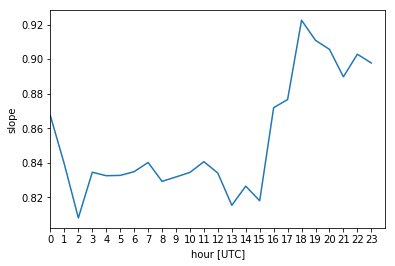

In [34]:
plt.plot(slopes)
plt.xticks(np.arange(24))
plt.xlim(0,24)
plt.xlabel('hour [UTC]')
plt.ylabel('slope')